# Abstract
This notebook is the extension of sequencing approach. Here we suggest that all time frame should be sequnced in smaller timeframes and a separate graph for each of this subframes should be build. The methodology for building a graph is completely the same as in sequencing, but the data is different.

In [1]:
import math
try:
    import sage
    from sage.graphs.hyperbolicity import hyperbolicity
    from sage.graphs.graph import Graph, DiGraph
    HAS_SAGE = True
except ImportError:
    HAS_SAGE = False
import warnings

import pandas as pd
import numpy as np
from typing import Callable, List, Tuple, Dict, Iterable, Any
from collections import defaultdict
from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from statsmodels.tsa.stattools import grangercausalitytests
from utils import time_consuming, any_in
from utils.preprocessing import standardize_df
from tqdm.notebook import tqdm
from scipy.signal import coherence
import seaborn as sns
import igraph as ig

In [2]:
ig.config["plotting.backend"] = "matplotlib"
ig.config["plotting.layout"] = "fruchterman_reingold"
ig.config["plotting.palette"] = "rainbow"

In [3]:
warnings.simplefilter("ignore")

In [4]:
df = pd.read_csv("../data/22ht1.csv")
df.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,time_s,x,y,0.0,1.0,2.0,3.0,...,509.0,510.0,511.0,512.0,513.0,514.0,515.0,516.0,517.0,518.0
0,0,0,0,67.70,876.202246,701.980008,-0.34655,-0.71631,-0.047737,0.793520,...,1.08940,-1.43040,1.28950,-1.73120,12.296000,0.490490,1.78360,-1.9901,-0.73521,2.0794
1,1,1,1,67.75,873.823553,698.247808,-0.46934,-0.72462,-0.026651,0.232830,...,0.37633,-2.80540,1.04790,-0.64049,7.207100,0.038311,1.26940,-2.3953,-0.62211,-2.9352
2,2,2,2,67.80,869.339334,684.910311,-0.79277,-0.90364,-0.063160,0.637430,...,0.38806,-2.21760,0.41558,-1.91790,8.628700,1.324600,1.81450,-1.8960,-0.47870,-1.2518
3,3,3,3,67.85,870.531773,678.403344,-1.04160,-1.10340,-0.197860,0.010588,...,0.42846,-2.65280,1.07950,-0.65687,6.032800,-1.038900,0.66639,-2.1342,-0.74338,-2.1278
4,4,4,4,67.90,873.077049,680.866207,-0.85335,-0.46933,0.164510,-0.079999,...,0.40836,0.80766,1.26150,-2.46150,-17.125999,0.016407,1.18670,-1.9257,-0.14995,-7.3924


# Data preprocessing

In [5]:
df = df.drop(["Unnamed: 0", "Unnamed: 0.2", "Unnamed: 0.1"], axis=1)
df_no_time = df.drop(["time_s"], axis=1)
df_norm = standardize_df(df_no_time)
df_norm = df_norm.assign(time_s=df.time_s)
df_norm

,x,y,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,510.0,511.0,512.0,513.0,514.0,515.0,516.0,517.0,518.0,time_s
0,0.707681,0.674414,0.019897,0.043888,0.049243,0.096324,0.112920,0.082477,0.136665,0.160537,...,0.349561,0.326807,0.198808,0.361026,0.331943,0.622760,0.151974,0.223625,0.363966,67.70
1,0.703936,0.670267,0.017008,0.043645,0.050695,0.069473,0.092660,0.078581,0.155205,0.156131,...,0.307666,0.311243,0.246539,0.304999,0.320617,0.575973,0.104238,0.246286,0.216556,67.75
2,0.696875,0.655447,0.009400,0.038416,0.048181,0.088849,0.097853,0.082543,0.146584,0.157218,...,0.325576,0.270506,0.190638,0.320651,0.352835,0.625572,0.163060,0.275021,0.266042,67.80
3,0.698753,0.648217,0.003547,0.032582,0.038906,0.058830,0.096063,0.096194,0.152227,0.130040,...,0.312316,0.313278,0.245822,0.292071,0.293635,0.521104,0.134998,0.221988,0.240290,67.85
4,0.702760,0.650954,0.007975,0.051102,0.063859,0.054492,0.091954,0.070946,0.132699,0.132882,...,0.417753,0.325003,0.166849,0.037102,0.320068,0.568448,0.159561,0.340890,0.085531,67.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13867,0.627335,0.669614,0.131957,0.060452,0.075920,0.063369,0.106140,0.088559,0.090102,0.239386,...,0.358985,0.177467,0.250799,0.262381,0.297928,0.454922,0.462753,0.376774,0.271909,761.05
13868,0.627625,0.669290,0.169948,0.057496,0.075044,0.049427,0.109355,0.098269,0.095624,0.248339,...,0.376473,0.324005,0.292048,0.273576,0.276360,0.468932,0.458175,0.331978,0.279592,761.10
13869,0.627959,0.669706,0.182970,0.054578,0.050331,0.069357,0.104534,0.098112,0.087022,0.233656,...,0.391725,0.185280,0.305160,0.280402,0.325606,0.420158,0.483482,0.343217,0.334032,761.15
13870,0.629061,0.672204,0.196220,0.066394,0.063159,0.065946,0.112147,0.089826,0.090092,0.238140,...,0.383360,0.193483,0.242061,0.247040,0.316153,0.462335,0.538800,0.283782,0.360215,761.20


## Build graphs
We would use the same approach as in our connection modeling, but this time we would use only coherence as no other metrics has shown good result previously.

In [6]:
class Edge:
    def __init__(self, src: Any, dst: Any, rho: float):
        self.src = src
        self.dst = dst
        self.rho = rho

In [7]:
def plot_graph_pyvis(edges: List[Edge], at_rho: float,
                     name: str="pyvis", dataframe: pd.DataFrame=df_norm):
    """
    Plots graph with help of networkx
    :param dataframe: pd.DataFrame: dataframe on each
    :param name: str: Name of visualisation
    :param edges: List[Edge]: list of graph edges
    :param: at_rho: float: rho which should be used for filtering edges
    :return: None
    """
    net = Network(notebook=True)
    net.add_nodes(dataframe.columns)
    edges_list = list()
    n = 0
    for edge in tqdm(edges):
        if edge.rho < at_rho:
            continue
        edges_list.append([edge.src, edge.dst])
        n += 1
    print("Visualizing %d edges" % len(edges_list))
    print("There is %d nodes in graph" % len(graph.keys()))
    net.add_edges(edges_list)
    net.show(f"../out/{name}.html")

In [8]:
# Generic method for building graph
def build_graph(rho: Callable,  n_eps: int = 1,
                exclude_columns: Tuple[str] = ('x', 'y', 'time_s',),
                use_lag: bool = True, dataframe=df_norm) -> Tuple[Dict[str, List[str]], List[Edge]]:
    """
    Builg graph with arbitary metrics
    :param dataframe: pd.DataFrame: a dataframe with neuron activity
    :param rho: Callable: metric which accepts two time series and returns float similarity value
    :param mu_min: float: minimal value of metric to state that one neuron activation depends on other
    :param n_eps: int: integer value of epsilon for shifting dataset, takes effect only if lag enabled
    :param exclude_columns: List[str] columns which should be ignored
    :param: use_lag: bool: Whether to lag time series
    :return: Tuple[Dict[str, List[str]], List[Edge]]: graph representation in from of mapping
                                   node name and list of node name it flows to and list of all
                                   edges graph.
    """
    df_neurons = dataframe.drop(list(exclude_columns), axis=1)
    graph = defaultdict(lambda: list())
    rho_avg = 0.0
    n = 0
    rho_values = list()
    edges = list()
    for a_column in tqdm(df_neurons.columns):
        if a_column in exclude_columns:
            continue
        for b_column in df_neurons.columns:
            if a_column == b_column:
                continue
            if b_column in exclude_columns:
                continue
            n += 1
            a = df_neurons[a_column]
            b = df_neurons[b_column]
            if use_lag:
                a = a[:-n_eps]
                b = b[n_eps:]
            result = rho(a, b)
            rho_values.append(result)
            rho_avg += result
            if not isinstance(result, float):
                raise TypeError(f"rho should return float, got {result}")
            graph[a_column].append(Edge(a_column, b_column, result))
            edges.append(Edge(a_column, b_column, result))
    if not any_in([None, math.inf, -math.inf], rho_values):
        plt.title("$\\rho$ distribution")
        sns.distplot(rho_values)
        plt.show()
    else:
        print("NaNs detected in rho values, would not build plots")
    return graph, edges

In [9]:
def get_slices(dataframe: pd.DataFrame, n: int) -> List[pd.DataFrame]:
    step = len(dataframe) // n
    result = list()
    for i in range(0, len(dataframe), step):
        result.append(dataframe[i: i + step].copy())
    return result

In [10]:
def coh(x, y, fs: int=1000, f_range: Tuple[int, int]=(1, 1000,)) -> float:
    f, c = coherence(x, y, fs)
    f_idx = np.logical_and(f >= f_range[0], f <= f_range[1])
    return float(np.mean(c[f_idx]))

In [11]:
slices = get_slices(dataframe=df_norm, n=20)

  0%|          | 0/519 [00:00<?, ?it/s]

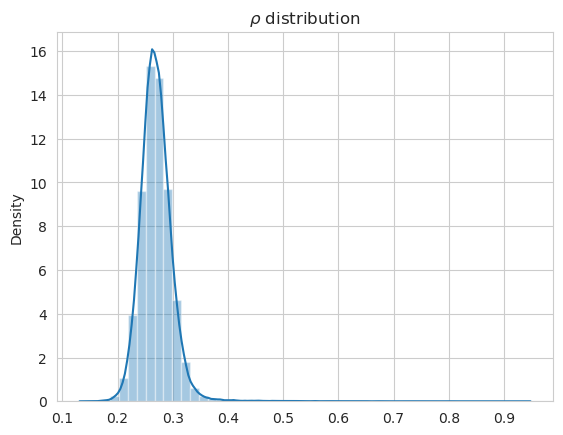

  0%|          | 0/268842 [00:00<?, ?it/s]

Visualizing 1996 edges
There is 519 nodes in graph
../out/coh_graph_slice_0.html


  0%|          | 0/519 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
graphs, edge_lists = list(), list()
i = 0
for slice in slices:
    if len(slice) < 100:
        print(f"WARNING: too small slice({len(slice)} entries), ignoring")
        continue
    graph, edges = build_graph(coh, dataframe=slice)
    plot_graph_pyvis(edges, 0.36, name="coh_graph_slice_%d" % i)
    graphs.append(graph)
    edge_lists.append(edges)
    i += 1

In [ ]:
dynamics = list()
for edges in edge_lists:
    if len(edges) < 500:
        continue
    avg = sum([edge.rho for edge in edges])
    avg /= len(edges)
    dynamics.append(avg)
plt.title("Dynamics of $\\bar\\rho$ over slices")
plt.plot(dynamics)
plt.show()

# Calculcate metrics

## Hyperbolicity

In [ ]:
if HAS_SAGE:
    def graph_from_edges(edges: List[Edge]) -> Graph:
        graph = Graph()
        vertices = set()
        for edge in edges:
            if edge.src not in vertices:
                graph.add_vertex(edge.src)
                vertices.add(edge.src)
            if edge.dst not in vertices:
                graph.add_vertex(edge.src)
                vertices.add(edge.dst)
            graph.add_edge(edge.src, edge.dst)
        return graph

In [ ]:
if HAS_SAGE:
    i = 0
    hs = list()
    for edges in edge_lists:
        i += 1
        h = hyperbolicity(graph_from_edges(edges))
        hs.append(h[0])

In [ ]:
if HAS_SAGE:
    plt.plot(hs)
    plt.show()

## Clusterization coefficient

In [ ]:
def edges_to_nx(edges: List[Edge], at_rho: float) -> nx.Graph:
    """
    Converts list of edges to networkx format
    :param edges: List[Edge]: list of edges that are used
    :param: at_rho: float: rho lower bound for filtering
    :return: None
    """
    G = nx.Graph()
    for edge in edges:
        if edge.rho < at_rho:
            continue
        G.add_edge(edge.src, edge.dst, rho=edge.rho)
    return G

In [ ]:
clusterization = list()
avg = lambda a: sum(a) / len(a)
for edges in edge_lists:
    clusterization.append(avg(nx.clustering(edges_to_nx(edges, 0.36), weight='rho').values()))

In [ ]:
plt.title("Clustering coefficient")
plt.plot(clusterization)
plt.show()

  0%|          | 0/554 [00:00<?, ?it/s]

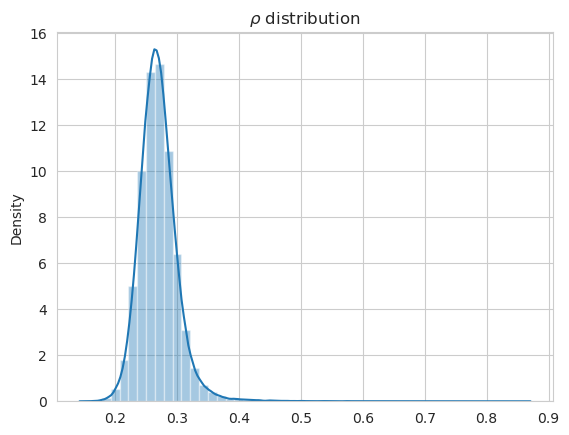

In [13]:
graph, edges = build_graph(coh, dataframe=slices[0])

In [24]:
def plot_igraph_to_file(edges: List[Edge], fname: str, rho_min: float=0.36):
    plt.rcParams["figure.figsize"] = (20, 20,)
    g = ig.Graph()
    vetrices = set()
    for edge in tqdm(edges):
        if edge.rho < rho_min:
            continue
        if edge.dst not in vetrices:
            g.add_vertex(edge.dst)
        if edge.src not in vetrices:
            g.add_vertex(edge.src)
        vetrices.add(edge.src)
        vetrices.add(edge.dst)
        g[edge.src, edge.dst] = edge.rho
    #plt.title(fname)
    ig.plot(g)
    plt.savefig(fname + ".png")

  0%|          | 0/306362 [00:00<?, ?it/s]

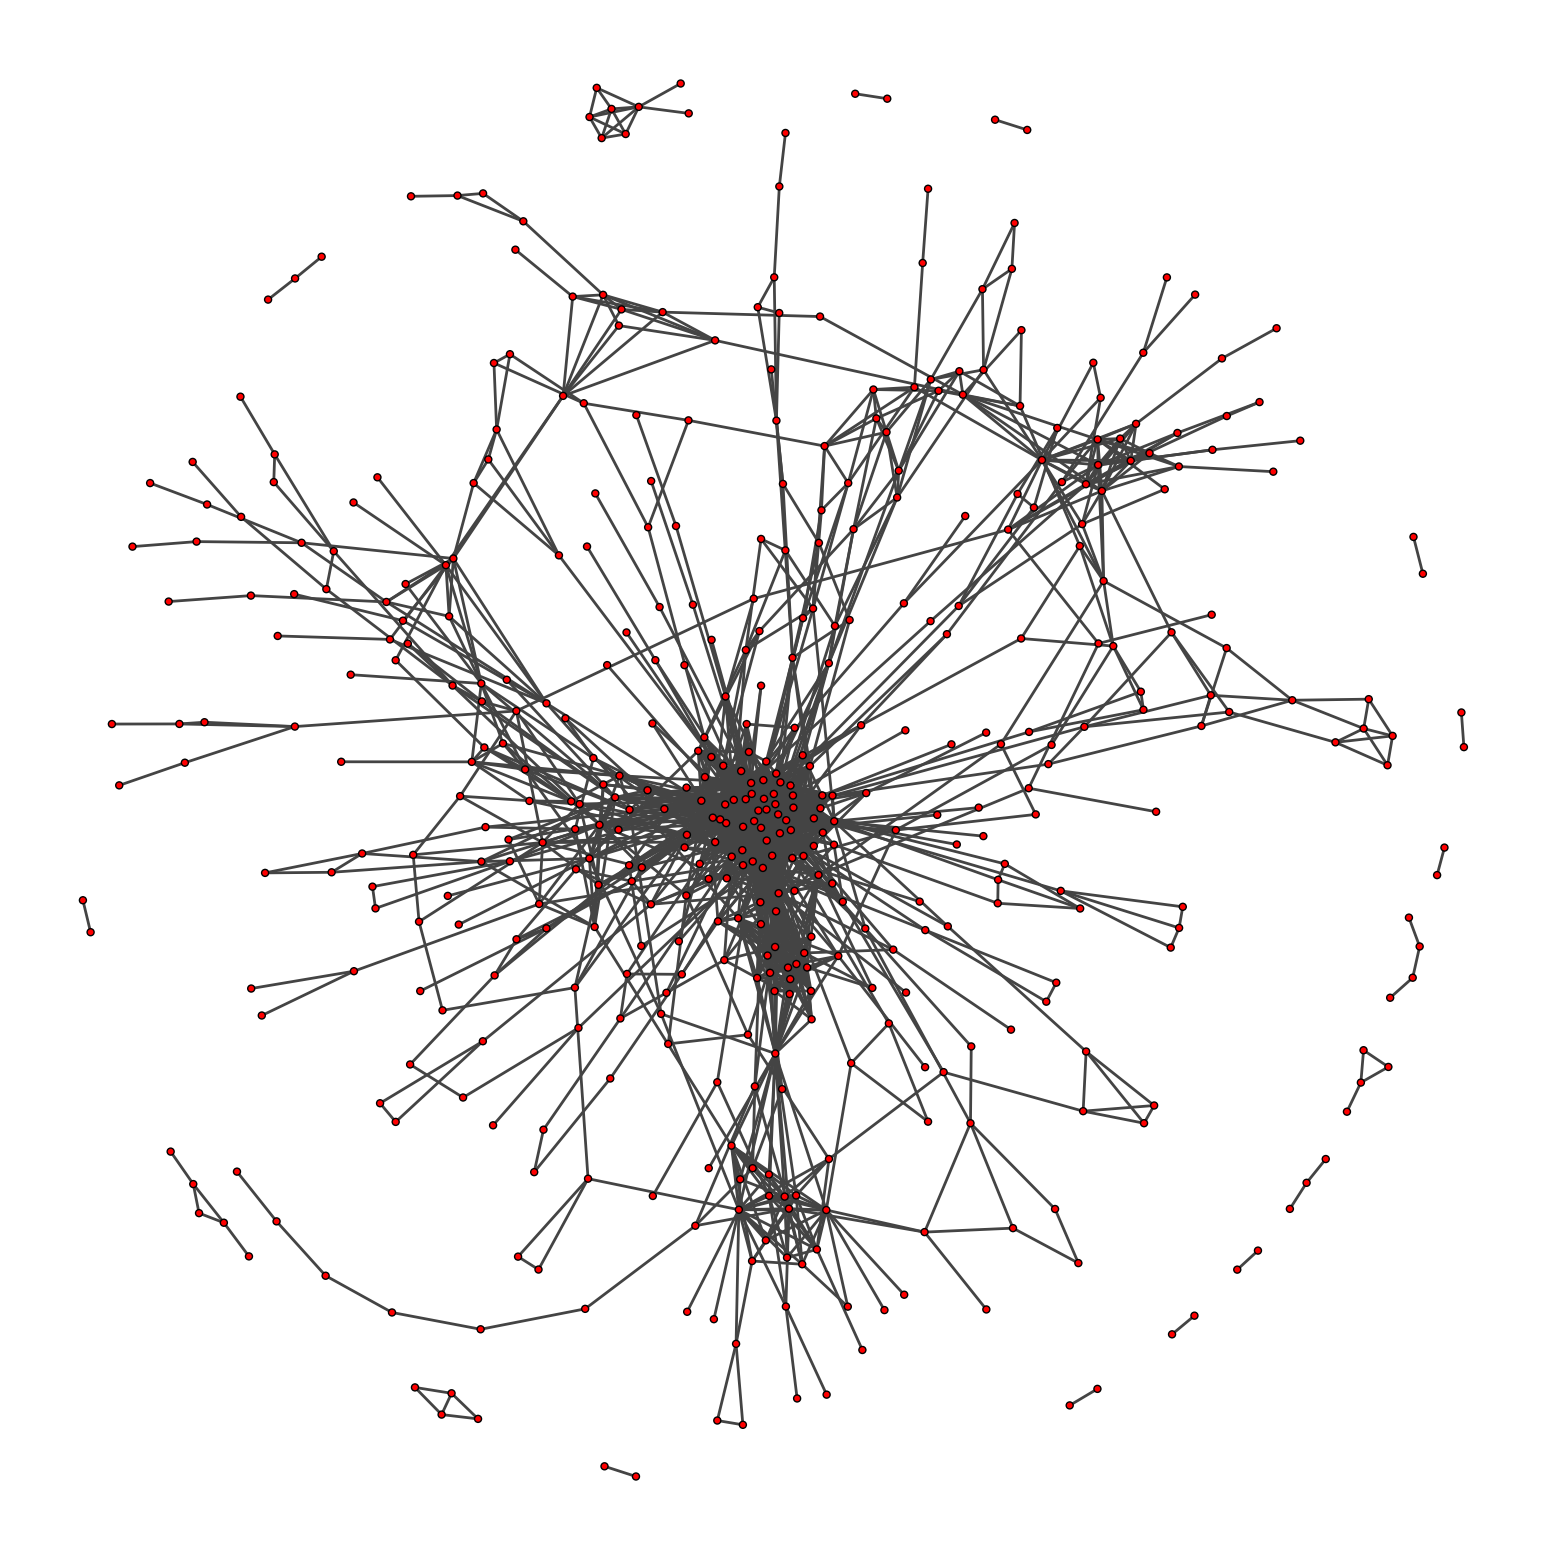

In [26]:
plot_igraph_to_file(edge_lists[0], "../out/test.png")

  0%|          | 0/306362 [00:00<?, ?it/s]

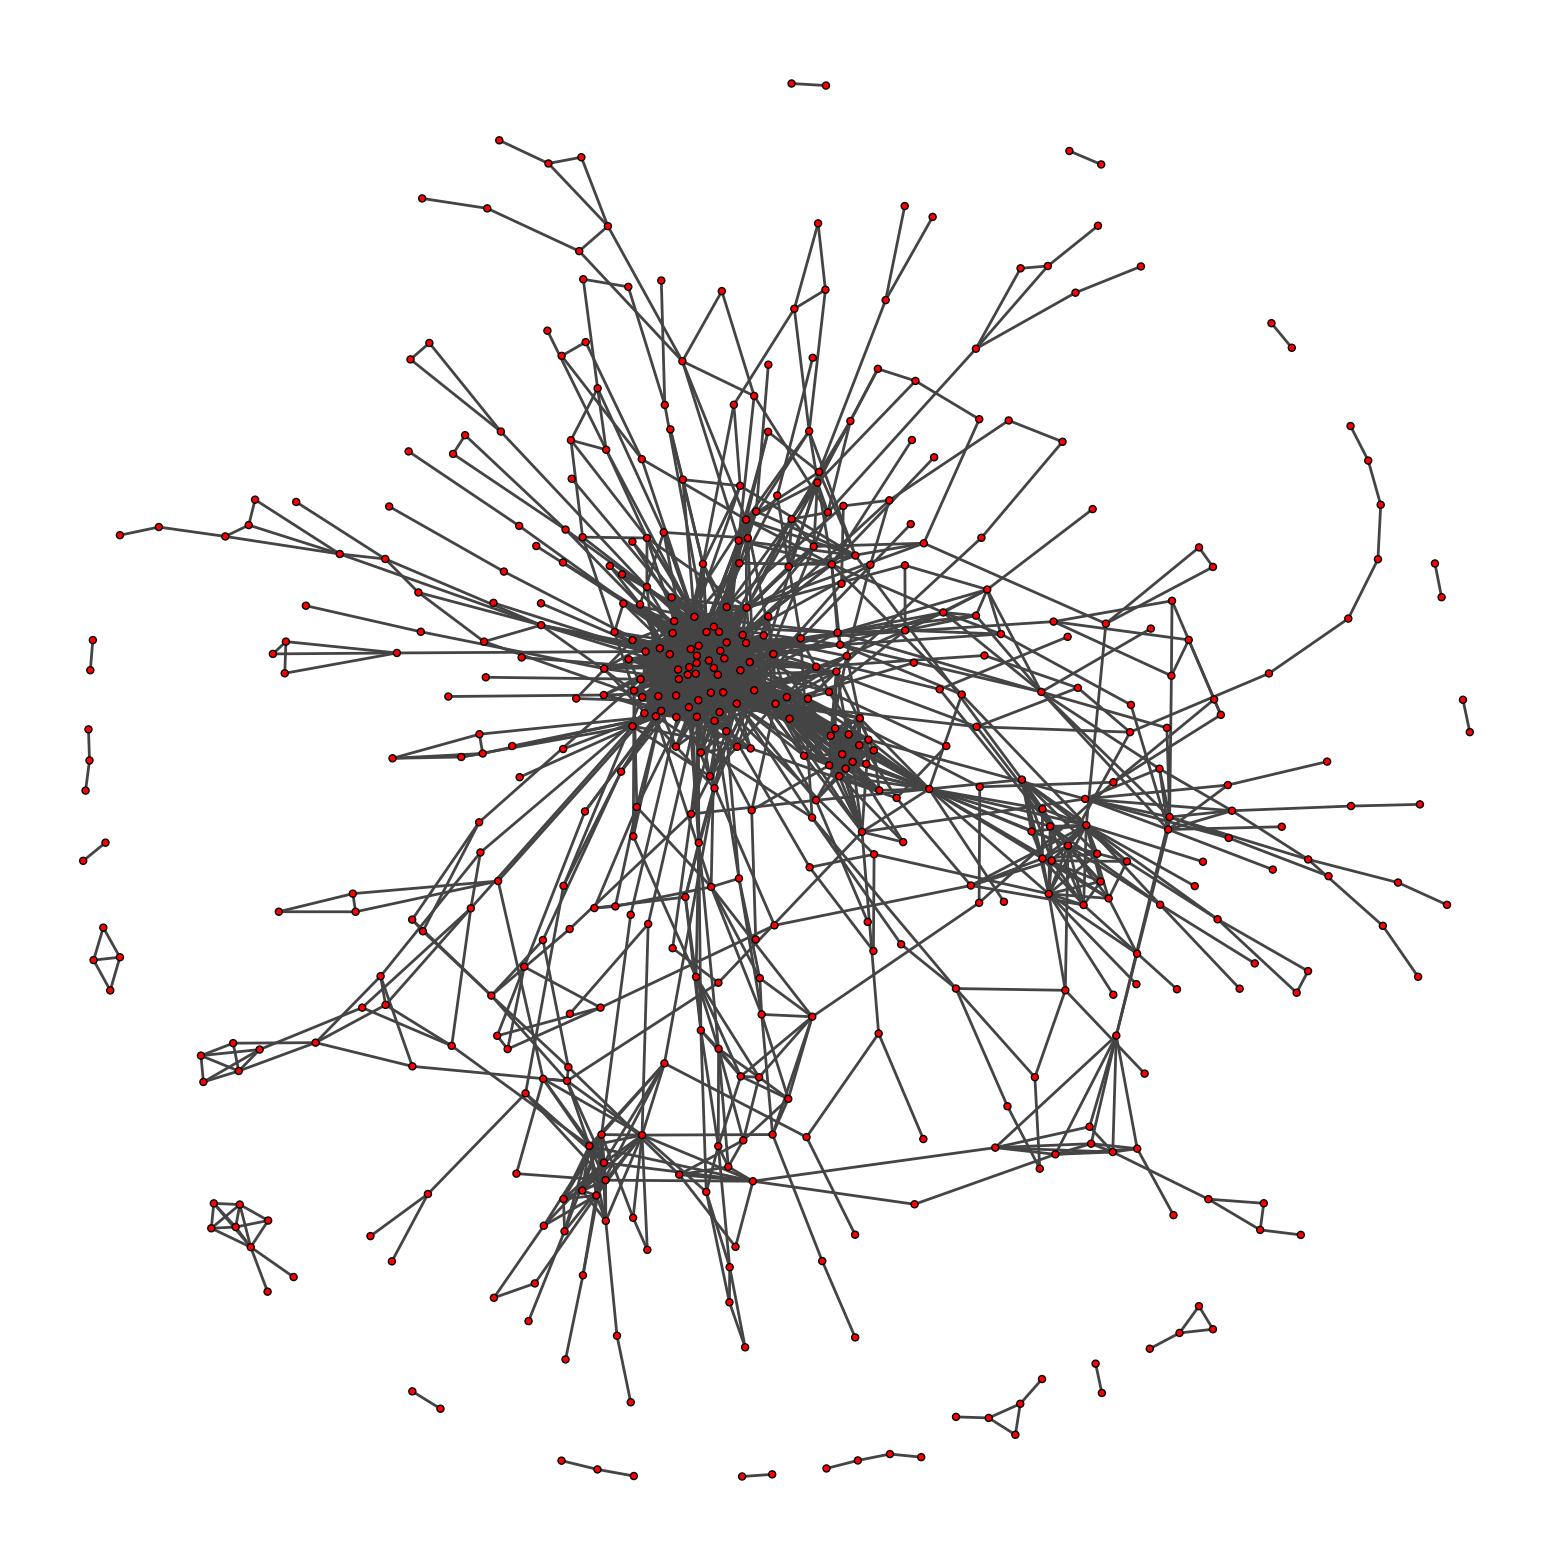

In [27]:
i = 0
for edges in edge_lists:
    plot_igraph_to_file(edges, f"../out/coh_graph_{i}")
    i += 1

# Activity in slices

In [18]:
edges = edge_lists[0]
edges.sort(key=lambda x: x.rho, reverse=True)

In [21]:
print(edges[0].rho)
src = edges[0].src
dst = edges[0].dst
print(f"{src} -> {dst}")

0.9402614535519562
416.0 -> 235.0


In [29]:
def plot_and_save_slice(n: int):
    plt.title(f"Neuron {src} vs. {dst} slice {n}")
    plt.scatter(slices[n][src], slices[n][dst])
    plt.savefig(f"../out/{src}_vs_{dst}_slice{n}.png")
    plt.show()

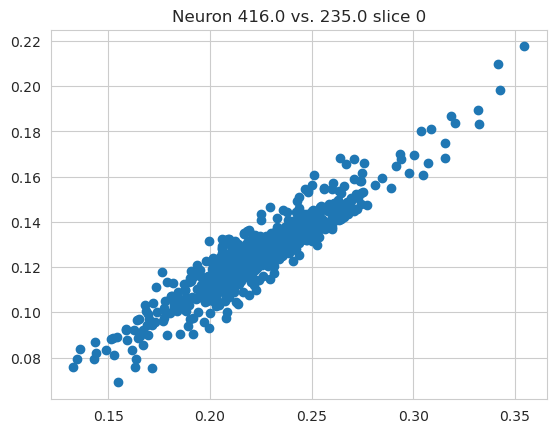

In [30]:
plot_and_save_slice(0)

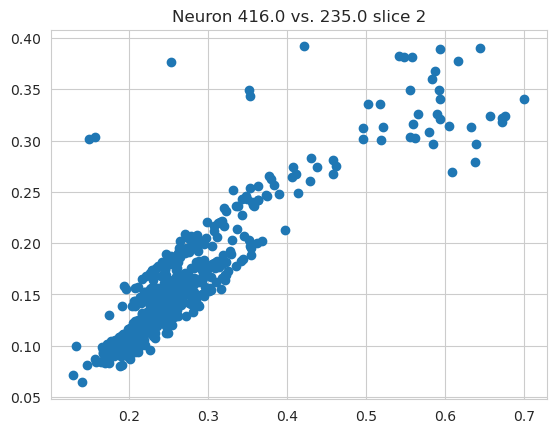

In [31]:
plot_and_save_slice(2)

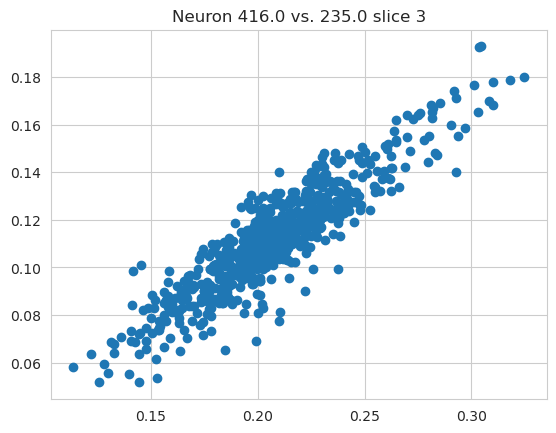

In [32]:
plot_and_save_slice(3)

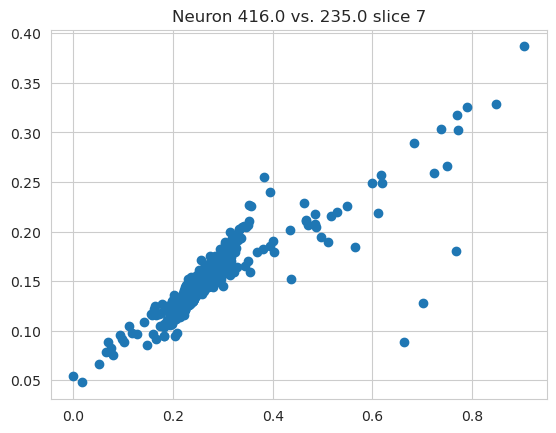

In [33]:
plot_and_save_slice(7)

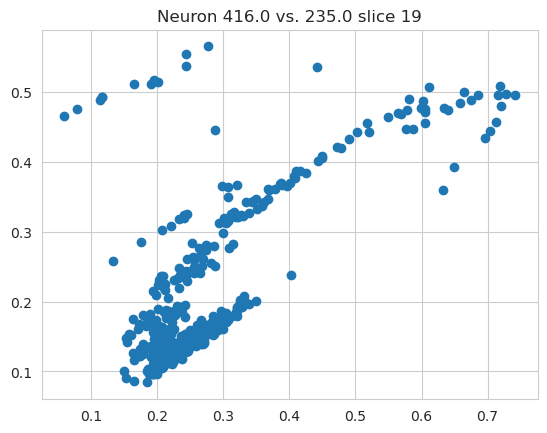

In [37]:
plot_and_save_slice(19)

In [38]:
print(edges[17].rho)
src = edges[17].src
dst = edges[17].dst
print(f"{src} -> {dst}")

0.7952040278762132
302.0 -> 105.0


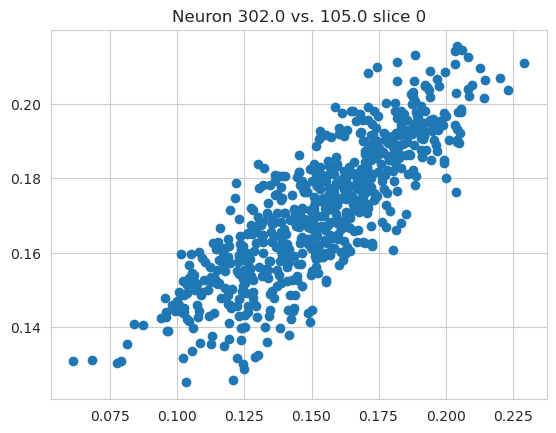

In [39]:
plot_and_save_slice(0)

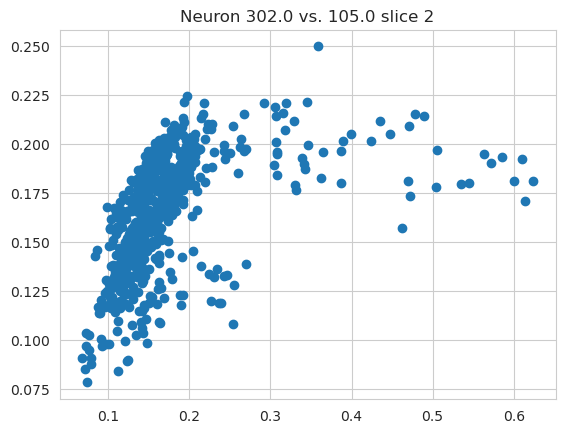

In [40]:
plot_and_save_slice(2)

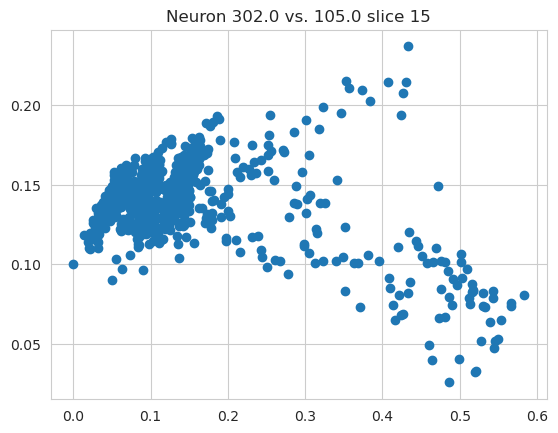

In [41]:
plot_and_save_slice(15)

In [43]:
plt.savefig("../out/3hole.png")
#TODO: maybe in slices neurons exhibit any correlation with position?

0      0.707681
1      0.703936
2      0.696875
3      0.698753
4      0.702760
         ...   
688    0.849387
689    0.849138
690    0.850151
691    0.850577
692    0.850312
Name: x, Length: 693, dtype: float64

# Modeling connections